# Amazon Stock price 

### The Stock Price for 1825 days are given in this dataset, starting from 23rd November 2015 to 20th November 2020. This is a real time dataset which is taken from Yahoo Finance Official Website.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
import os
import math
import warnings
warnings.filterwarnings("ignore")


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.plotting import lag_plot
from pmdarima.arima import ADFTest
from statsmodels.tsa.holtwinters import Holt,SimpleExpSmoothing,ExponentialSmoothing,HoltWintersResults

In [2]:
# For graphing purpose, can change 
plt.style.use('seaborn-bright')
plt.rcParams.update({'figure.figsize': (10, 6)})
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df= pd.read_csv("D:/yahoo finance stock market/stock_market_yahoo_finance.csv")
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index 
df = df.set_index('Date')

In [4]:
df.head(500)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107
...,...,...,...,...,...,...
2017-04-01,2370.350098,2362.600098,2364.820068,2362.719971,3.354110e+09,2362.719971
2017-04-02,2370.350098,2362.600098,2364.820068,2362.719971,3.354110e+09,2362.719971
2017-04-03,2365.870117,2344.729980,2362.340088,2358.840088,3.416400e+09,2358.840088


In [5]:
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

### No Null values, complete Dataset

In [6]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1825.000000,1825.000000,1825.000000,1825.000000,1.825000e+03,1825.000000
mean,2660.718673,2632.817580,2647.704751,2647.856284,3.869627e+09,2647.856284
std,409.680853,404.310068,407.169994,407.301177,1.087593e+09,407.301177
min,1847.000000,1810.099976,1833.400024,1829.079956,1.296540e+09,1829.079956
25%,2348.350098,2322.250000,2341.979980,2328.949951,3.257950e+09,2328.949951
50%,2696.250000,2667.840088,2685.489990,2683.340088,3.609740e+09,2683.340088
75%,2930.790039,2900.709961,2913.860107,2917.520020,4.142850e+09,2917.520020
max,3645.989990,3600.159912,3612.090088,3626.909912,9.044690e+09,3626.909912


## There are six columns given:

##### High -> Highest Price of the stock for that particular date.

##### Low -> Lowest Price of the stock for that particular date.

##### Open -> Opening Price of the stock.

##### Close -> Closing Price of the stock.

##### Volume -> Total amount of Trading Activity.

##### AdjClose -> Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

In [7]:
df.shape

(1825, 6)

In [8]:
print(df.index.min())
print(df.index.max())


2015-11-23 00:00:00
2020-11-20 00:00:00


### plotting the data

Text(0, 0.5, 'Close')

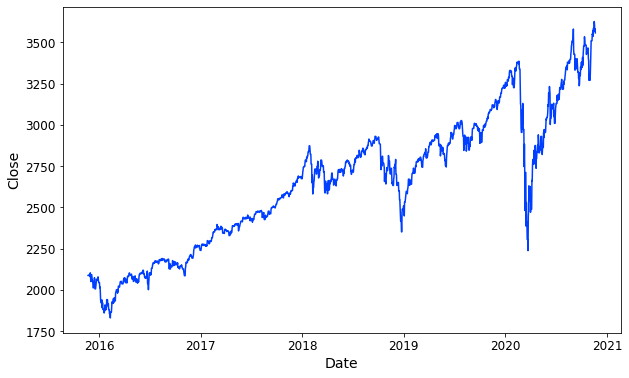

In [9]:
plt.plot(df["Close"])
plt.xlabel("Date")
plt.ylabel("Close")

#### Plotting the data after downsampling using mean

Text(0, 0.5, 'Close')

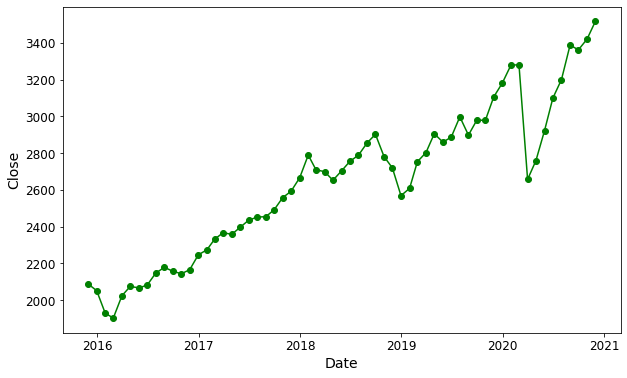

In [10]:
plt.plot(df["Close"].resample("M").mean(), color='g', marker='o')
plt.xlabel("Date")
plt.ylabel("Close")


### We can observe that there are no huge variations in the opening-closing price and the high-low prices & there is a upward trend with respect to Time.

    There were huge dips in the stock prices 2 times, once close to 2019 and once in March 2020(owing to Pandemic).

    There was an overall increase in the stock price from 2017 to 2018.

    The stock prices started to increase from the latter half for the year 2020

    The stock price went drastically down from starting of 2018 to 2019

### Decomposition Implementation

A given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

These components are defined as follows:
Level: The average value in the series.
Trend: The increasing or decreasing value in the series.
Seaso# nality: The repeating short-term cycle in the series.
Noise: The random variation in the series.

All series have a level and noise. The trend and seasonality components are optional. It is helpful to think of the components as combining either additively or multiplicatively.

 An additive model suggests that the components are added together as follows:

    y(t) = Level + Trend + Seasonality + Noise

An additive model is linear where changes over time are consistently made by the same amount. A linear seasonality has the same frequency (width of cycles) and amplitude (height of cycles).

 A multiplicative model suggests that the components are multiplied together as follows:

    y(t) = Level * Trend * Seasonality * Noise

A multiplicative model is nonlinear, such as quadratic or exponential. Changes increase or decrease over time. A non-linear seasonality has an increasing or decreasing frequency and/or amplitude over time.

Decomposition provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model.

Each of these components are something you may need to think about and address during data preparation, model selection, and model tuning. You may address it explicitly in terms of modeling the trend and subtracting it from your data, or implicitly by providing enough history for an algorithm to model a trend if it may exist.

In order to implement the naive or classical decomposition method, we use the seasonal_decompose() method provided by the statsmodels library. It requires you to specify whether the model is Additive or Multiplicative.

In [11]:
df_new=df.drop(['High','Low','Open','Adj Close','Volume'],axis=1)
df_new.head()

,Close
Date,
2015-11-23,2086.590088
2015-11-24,2089.139893
2015-11-25,2088.870117
2015-11-26,2088.870117
2015-11-27,2090.110107


In [12]:
df_new_close= df_new['Close']

In [13]:
df_close_month = df_new.resample('MS').mean()
df_close_month.head(10)

,Close
Date,
2015-11-01,2088.026306
2015-12-01,2051.352913
2016-01-01,1927.887408
2016-02-01,1902.567938
2016-03-01,2023.688059
2016-04-01,2074.564001
2016-05-01,2066.167102
2016-06-01,2081.775667
2016-07-01,2147.336434


In [14]:
df_close_month_1= df_close_month["Close"]

In [15]:
def decompose(df):
    """
    A function that returns the trend, seasonality and residual captured by applying
    additive model."""
    result_additive = seasonal_decompose(df, model = 'add', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (10, 6)})
    result_additive.plot().suptitle('Additive Decompose', fontsize=20)
    plt.show()
    
    return result_additive

#### The seasonal_decompose() function returns a result object. The result object contains arrays to access four pieces of data from the decomposition: Observed Series, Trend, Seasonality, and residual. We have plotted both Multiplicative as well as Additive model, so that we can decide which one of the two should be used.

# Close

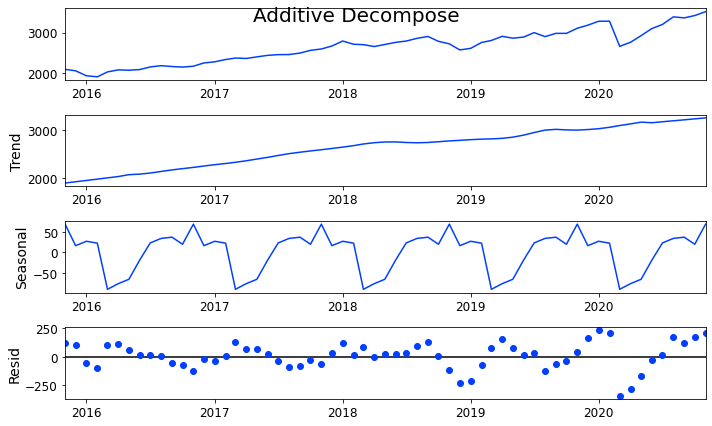

In [16]:
result_additive_close = decompose(df_close_month)

In [17]:
df_reconstructed_close= pd.concat([result_additive_close.seasonal, result_additive_close.trend, result_additive_close.resid, result_additive_close.observed], axis=1)
df_reconstructed_close.columns= ['Seasonal','Trend','Residual','Actual_values']
df_reconstructed_close

,Seasonal,Trend,Residual,Actual_values
Date,,,,
2015-11-01,67.952610,1901.021995,119.051701,2088.026306
2015-12-01,16.263919,1927.898884,107.190110,2051.352913
2016-01-01,26.831742,1954.775774,-53.720108,1927.887408
2016-02-01,22.268022,1981.652663,-101.352747,1902.567938
2016-03-01,-88.556289,2008.529553,103.714795,2023.688059
...,...,...,...,...
2020-07-01,22.890054,3163.201147,14.181378,3200.272579
2020-08-01,33.648586,3183.032445,171.278670,3387.959701
2020-09-01,36.658951,3202.863743,122.961632,3362.484326


## Stationarity
    Subtract the previous value from the current value. Now if we just difference once, we might not get the a stationary   series ; we might need to do that multiple times. 
    The minimum number of differencing operations needed to make the stationary needs to be inputed into the ARIMA model.

## ADF Test
    The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

   - Null Hypothesis: The series has a unit root (value of a =1)

   - Alternate Hypothesis: The series has no unit root.

    If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.
    
    We'll use the Augmented Dickey Fuller Test to check if the stock price series is stationary or not.
    
    So, if the p-value of the test is less than the significance level(0.05) then we can reject the null hypothesis and infer that the time series model is indeed  stationary.
    If the p-value is greater than 0.05 then we'll need to find the order of differencing.


In [18]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

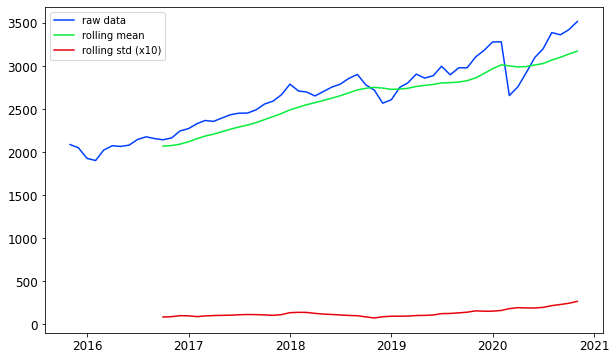

In [19]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(df_close_month_1,'raw data')

### Augmented Dickey-Fuller Test for checking the Stationarity

In [20]:
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' 
                                                                                if v<dftest[0] 
                                                                                else '', 100-int(k[:-1])))

In [21]:
ADF_test(df_close_month_1,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.397
P-value = 0.911
Critical values :
	1%: -3.5443688564814813 - The data is not stationary with 99% confidence
	5%: -2.9110731481481484 - The data is not stationary with 95% confidence
	10%: -2.5931902777777776 - The data is not stationary with 90% confidence


#### Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

#### The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

#### Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

### To make the Time series stationary, "Differencing once" 

 > Is the lag 1 differencing data stationary ?
Test statistic = -7.144
P-value = 0.000
Critical values :
	1%: -3.5463945337644063 - The data is  stationary with 99% confidence
	5%: -2.911939409384601 - The data is  stationary with 95% confidence
	10%: -2.5936515282964665 - The data is  stationary with 90% confidence


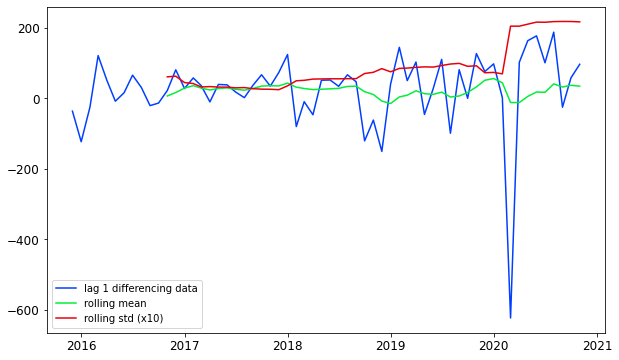

In [22]:
df_close_adj = df_close_month_1 - df_close_month_1.shift(1)
df_close_adj = df_close_adj.dropna()
test_stationarity(df_close_adj,'lag 1 differencing data')
ADF_test(df_close_adj,'lag 1 differencing data')

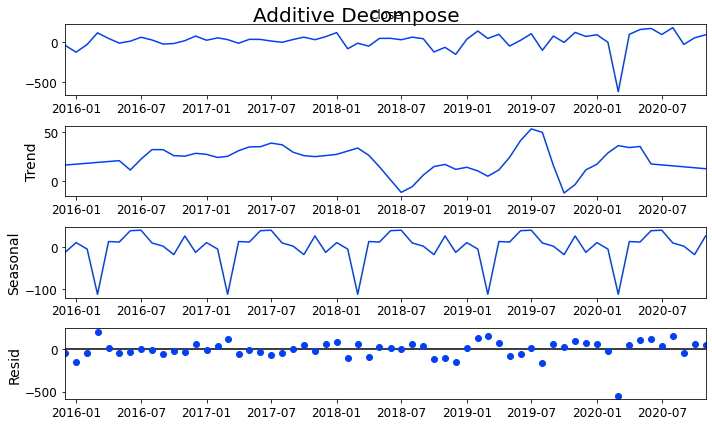

In [23]:
decompose(df_close_adj)

#### After differencing once, we get the p-value which is less than the significance level(0.05) and the ADF statistic is lower than any of the critical values.

### Autocorrelation function

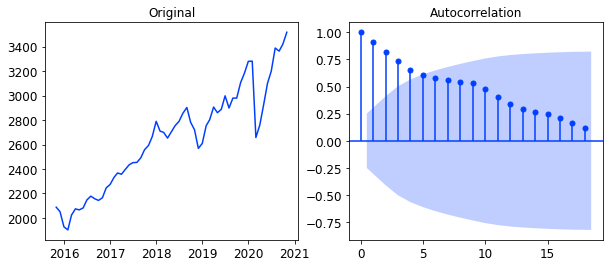

In [24]:
fig, (axis_1 , axis_2) = plt.subplots(1,2, figsize=(10,4))
axis_1.plot(df_close_month)
axis_1.set_title("Original")
plot_acf(df_close_month, ax=axis_2);

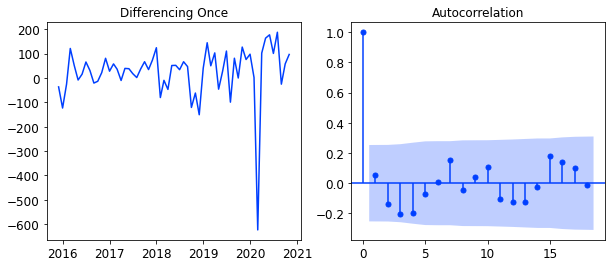

In [25]:
diff= df_close_month.diff().dropna()
fig, (axis_1 , axis_2) = plt.subplots(1,2, figsize=(10,4))
axis_1.plot(diff)
axis_1.set_title("Differencing Once")
plot_acf(diff, ax=axis_2);


 #### Therefore, first order differencing is enough for our model. Hence, d is taken as "one"

## P
    p is the order of the Auto Regressive(AR) term. It refers to the number of lags to be used as Predictors.
    We can find out required number of AR terms by inspecting the Partial Autocorrelation(PACF) plot
    The partial autocorrelation represents the correlation between the series and its lags.

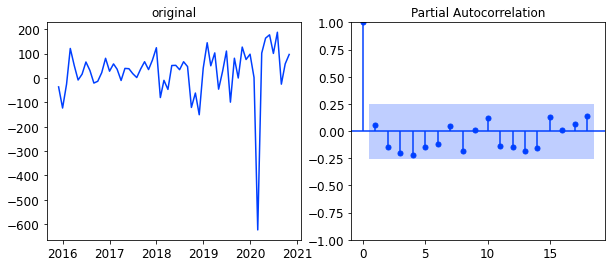

In [26]:
diff= df_close_month.diff().dropna()
fig, (axis_1 , axis_2) = plt.subplots(1,2, figsize=(10,4))
axis_1.plot(diff)
axis_1.set_title("original")
axis_2.set_ylim(-1,1)
plot_pacf(diff, ax=axis_2);

#### We can observe that there is no lag value present for which PACF crosses the upper confidence interval for the first time.

## q
In moving average the current value of time series is a linear combination of past errors. We assume the errors to be independently distributed with the normal distribution. Order q of the MA process is obtained from the ACF plot, this is the lag after which ACF crosses the upper confidence interval for the first time

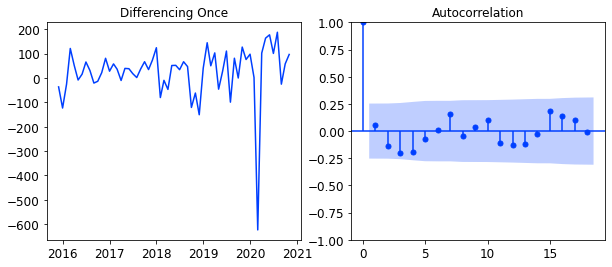

In [27]:
diff= df_close_month.diff().dropna()
fig, (axis_1 , axis_2) = plt.subplots(1,2, figsize=(10,4))
axis_1.plot(diff)
axis_1.set_title("Differencing Once")
axis_2.set_ylim(-1,1)
plot_acf(diff, ax=axis_2);

#### We can observe that there is no lag value present for which ACF crosses the upper confidence interval for the first time.

In [28]:
arima_model =  auto_arima(df_close_month_1)
arima_model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

## Train test split

In [29]:
n= int(len(df_close_month_1)*0.75)
train_df= (df_close_month_1)[:n]
test_df= (df_close_month_1)[n:]
print(train_df.head())
print(len(train_df))

Date
2015-11-01   2088.02630615
2015-12-01   2051.35291315
2016-01-01   1927.88740786
2016-02-01   1902.56793844
2016-03-01   2023.68805916
Freq: MS, Name: Close, dtype: float64
45


In [30]:
print(test_df.head())
print(len(test_df))

Date
2019-08-01   2898.17257592
2019-09-01   2979.19866536
2019-10-01   2978.98676128
2019-11-01   3105.80598958
2019-12-01   3181.54837135
Freq: MS, Name: Close, dtype: float64
16


### PACF plot for Training set

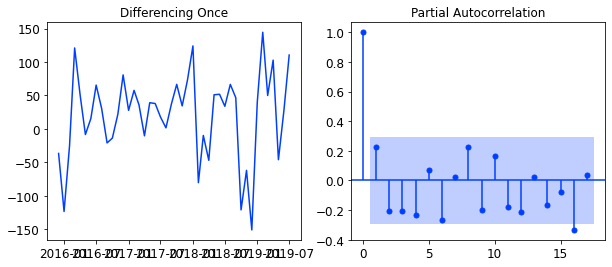

In [31]:
diff_train= train_df.diff().dropna()
fig, (axis_1 , axis_2) = plt.subplots(1,2, figsize=(10,4))
axis_1.plot(diff_train)
axis_1.set_title("Differencing Once")
plot_pacf(diff_train, ax=axis_2);

### ACF plot for Training set

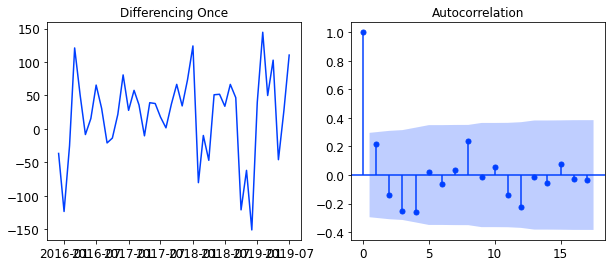

In [32]:
diff_train= train_df.diff().dropna()
fig, (axis_1 , axis_2) = plt.subplots(1,2, figsize=(10,4))
axis_1.plot(diff_train)
axis_1.set_title("Differencing Once")
plot_acf(diff_train, ax=axis_2);

In [33]:
auto_arima_train= auto_arima(train_df)
auto_arima_train

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [34]:
train_model_autoARIMA=auto_arima(train_df, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              
                      d=None,           
                      seasonal=True,   
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(train_model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=385.642, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=385.420, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=385.777, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=384.854, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=386.850, Time=0.50 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=384.082, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=385.246, Time=0.04 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=386.077, Time=0.40 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=384.503, Time=0.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=386.026, Time=0.28 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=385.81

### Ljung Box
    The Ljung–Box test is a type of statistical test of whether any of a group of autocorrelations of a time series are different from zero. Instead of testing randomness at each distinct lag, it tests the “overall” randomness based on a number of lags and is, therefore, a portmanteau test.
   - Ho: The model shows the goodness of fit(The autocorrelation is zero) 
   
   - Ha: The model shows a lack of fit(The autocorrelation is different from zero)
   
    My model here does not satisfy the goodness of fit condition because Probability(Q)=0.47. 

### Heteroscedasticity
    Heteroscedasticity means unequal scatter. In regression analysis, we talk about heteroscedasticity in the context of the residuals or error term. Specifically, heteroscedasticity is a systematic change in the spread of the residuals over the range of measured values.
    
    My residuals are heteroscedastic in nature since Probability(Heteroskadisticy) is close to 0 

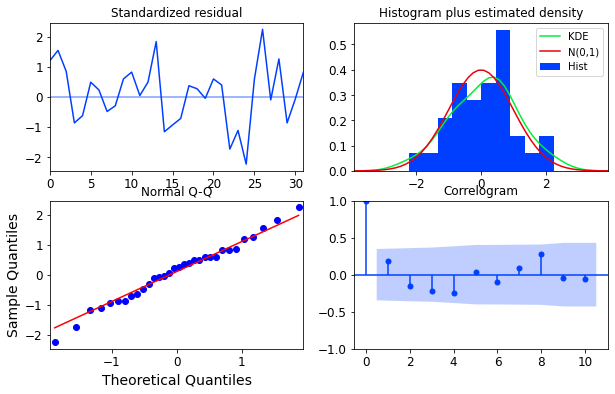

In [35]:
train_model_autoARIMA.plot_diagnostics()
plt.show()

### Interpretation

- Top left: The residual errors seem to fluctuate around a mean of zero and acted as white noise


- Top Right: The density plot suggest normal distribution with mean zero.


- Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.


- Bottom Right: The Correlogram , i.e , ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

## Forecasting

In [36]:
test_df.head(10)

Date
2019-08-01   2898.17257592
2019-09-01   2979.19866536
2019-10-01   2978.98676128
2019-11-01   3105.80598958
2019-12-01   3181.54837135
2020-01-01   3279.13679751
2020-02-01   3280.88376381
2020-03-01   2656.98193359
2020-04-01   2759.02799479
2020-05-01   2922.43740549
Freq: MS, Name: Close, dtype: float64

In [37]:
prediction = pd.DataFrame(train_model_autoARIMA.predict(n_periods = 16),index=test_df.index)
prediction.columns = ['predicted_stock_value']
prediction =prediction['predicted_stock_value']
prediction

Date
2019-08-01   3036.47640525
2019-09-01   3050.67451133
2019-10-01   3011.34797715
2019-11-01   3004.41371443
2019-12-01   2998.24852064
2020-01-01   3047.30570473
2020-02-01   3113.04643175
2020-03-01   3146.22430958
2020-04-01   3171.32415079
2020-05-01   3181.14213896
2020-06-01   3217.57453801
2020-07-01   3272.35292385
2020-08-01   3299.07640055
2020-09-01   3329.51779493
2020-10-01   3324.35430840
2020-11-01   3326.71963409
Freq: MS, Name: predicted_stock_value, dtype: float64

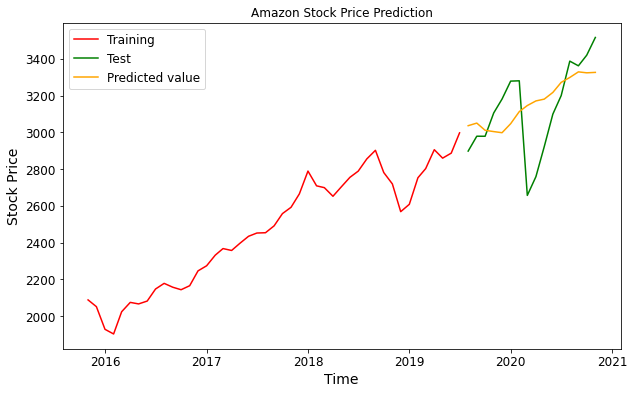

In [38]:

plt.figure(figsize=(10,6))
plt.plot(train_df,color='red',label="Training")
plt.plot(test_df,color='green',label="Test")

plt.plot(prediction,color='orange',label="Predicted value")
plt.title( 'Amazon Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=12)
plt.show()



In [39]:
# prediction_1, se, conf = results.predict(13, alpha=0.05)  # 95% confidence
# prediction_1_series = pd.Series(prediction_1, index=test_df.index)
# lower_series = pd.Series(conf[:, 0], index=test_df.index)
# upper_series = pd.Series(conf[:, 1], index=test_df.index)
# plt.figure(figsize=(12,5), dpi=100)
# plt.plot(train_df, label='training')
# plt.plot(test_df, color = 'blue', label='Actual Stock Price')
# plt.plot(prediction_1_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
# plt.title('Amazon Stock Price Prediction')
# plt.xlabel('Month')
# plt.ylabel('Actual Stock Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()


## Report Performance

In [40]:
mse = mean_squared_error(test_df, prediction)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_df, prediction)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_df, prediction))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(prediction - test_df)/np.abs(test_df))
print('MAPE: '+str(mape))


MSE: 43801.05946615053
MAE: 167.7994402154451
RMSE: 209.28702651179918
MAPE: 0.05597146674046523


### RMSE = 209.3 & around 5.6% MAPE(Mean Absolute Percentage Error) implies the model is about 94.4% accurate in predicting the test set observations.

### Simple Exponential Smoothing

In [41]:
df_close_month=df['Close'].resample('MS').mean()
df_close_month.head(20)
n= int(len(df_close_month)*0.75)
train_df_1= df_close_month[:n]
test_df_1= df_close_month[n:]
print(len(train_df_1))
print(len(test_df_1))

45
16


## Simple   Exponential Smoothing

Prediction Using Simple Exponential Smoothing The simplest of the exponentially smoothing methods are naturally called simple exponential smoothing. This method is suitable for forecasting data with no clear trend or seasonal pattern.

Using the naïve method, all forecasts for the future are equal to the last observed value of the series. Hence, the naïve method assumes that the most recent observation is the only important one, and all previous observations provide no information for the future. This can be thought of as a weighted average where all of the weight is given to the last observation.

Using the average method, all future forecasts are equal to a simple average of the observed data. Hence, the average method assumes that all observations are of equal importance, and gives them equal weights when generating forecasts.

We often want something between these two extremes. For example, it may be sensible to attach larger weights to more        recent observations than to observations from the distant past. This is exactly the concept behind simple exponential smoothing. Forecasts are calculated using weighted averages, where the weights decrease exponentially as observations come from further in the past — the smallest weights are associated with the oldest observations.

So large value of α (α denotes smoothing parameter)denotes that recent observations are given higher weight and a lower value of α denoted that more weightage is given to distant past values.
    
#### Modelling Using Simple Exponential Smoothing:
\begin{align}
F_{t+1} = \sum_{i=0}^{t-1} α(1-α)^i y_{t-i} + (1-α)^t F_1
\end{align}

Where, $F_{t+1}$ : Forecasted value of time series at time t+1 ,
$F_t$ : Forecasted value of time series at time t

    -In fit1, we explicitly provide the model with the smoothing parameter α=0.2
    -In fit2, we choose an α=0.6
    -In fit3, we use the auto-optimization that allow statsmodels to automatically find an optimized value for us. This is  the recommended approach.

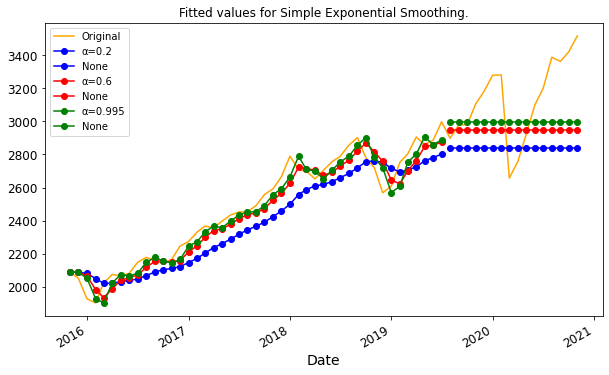

In [42]:
plt.plot(df_close_month,color='orange',label="Original")

# Simple Exponential Smoothing
fit_1 = SimpleExpSmoothing(train_df_1).fit(smoothing_level=0.2,optimized=False)
forecast_1 = fit_1.forecast(16).rename(r'α=0.2')
# plot 1
forecast_1.plot(marker='o', color='blue', legend=True)
fit_1.fittedvalues.plot(marker='o',  color='blue')

fit_2 = SimpleExpSmoothing(train_df_1).fit(smoothing_level=0.6,optimized=False)
forecast_2 = fit_2.forecast(16).rename(r'α=0.6')
# plot 2
forecast_2.plot(marker='o', color='red', legend=True)
fit_2.fittedvalues.plot(marker='o', color='red')


fit_3 = SimpleExpSmoothing(train_df_1).fit()
forecast_3 = fit_3.forecast(16).rename(r'α=%s'%fit_3.model.params['smoothing_level'])
# plot 3
forecast_3.plot(marker='o', color='green', legend=True)
fit_3.fittedvalues.plot(marker='o', color='green')
plt.title("Fitted values for Simple Exponential Smoothing.")
plt.legend()
plt.show()


### Fitted values for Simple Exponential Smoothing.

In [43]:
test_df.head()

Date
2019-08-01   2898.17257592
2019-09-01   2979.19866536
2019-10-01   2978.98676128
2019-11-01   3105.80598958
2019-12-01   3181.54837135
Freq: MS, Name: Close, dtype: float64

In [44]:
print( forecast_1.head())


2019-08-01   2841.41749337
2019-09-01   2841.41749337
2019-10-01   2841.41749337
2019-11-01   2841.41749337
2019-12-01   2841.41749337
Freq: MS, Name: α=0.2, dtype: float64


In [45]:
print(forecast_2.head(5))

2019-08-01   2948.26080882
2019-09-01   2948.26080882
2019-10-01   2948.26080882
2019-11-01   2948.26080882
2019-12-01   2948.26080882
Freq: MS, Name: α=0.6, dtype: float64


In [46]:
print(forecast_3.head(5))

2019-08-01   2996.98320438
2019-09-01   2996.98320438
2019-10-01   2996.98320438
2019-11-01   2996.98320438
2019-12-01   2996.98320438
Freq: MS, Name: α=0.995, dtype: float64


### RMSE checking

In [47]:
print(f"RMSE value for fit 1 : {math.sqrt(mean_squared_error(test_df_1, forecast_1))}")
print(f"RMSE value for fit 2 : {math.sqrt(mean_squared_error(test_df_1, forecast_2))}")
print(f"RMSE value for fit 3 : {math.sqrt(mean_squared_error(test_df_1, forecast_3))}")


RMSE value for fit 1 : 372.1372209521594
RMSE value for fit 2 : 298.1748464076985
RMSE value for fit 3 : 271.8076670971739


   - Since the lowest RMSE score is for α=0.995 , The best output is given when α= 0.995, indicating recent observations are given the highest weight. 
   

## DOUBLE EXPONENTIAL SMOOTHING-HOLT’S TREND METHOD

   - The basic equations for Holt’s Method are:

\begin{align}
µ_{t} = α y_{t} + (1-α) (µ_{t-i} + T_{t-1})\\
T_{t} = β (µ_{t} - µ_{t-1})  + (1-β) T_{t-1}\\
\end{align}
\begin{align}
F_{t+m} = µ_{t} + m T_{t}
\end{align}
Where,
$µ_{t}$ : Exponentially smoothed value of the series at time t ,

$y_{t}$ : Actual observation of time series at time t ,

$T_{t}$ : Trend Estimate ,

$α$ : Exponential Smoothing Constant for the data ,

$β$ : Smoothing constant for trend ,

$F_{t+m}$ : m period ahead forecasted value.

#### Modeling Using Holt’s Model: Under this, we took three cases:
    -In fit4, we explicitly provide the model with the smoothing parameter α=0.8, β*=0.2.
    -In fit5, we use an exponential model rather than a Holt’s additive model(which is the default).
    -In fit6, we use a damped version of the Holt’s additive model but allow the dampening parameter ϕ to be optimized while fixing the values for α=0.8, β*=0.2.

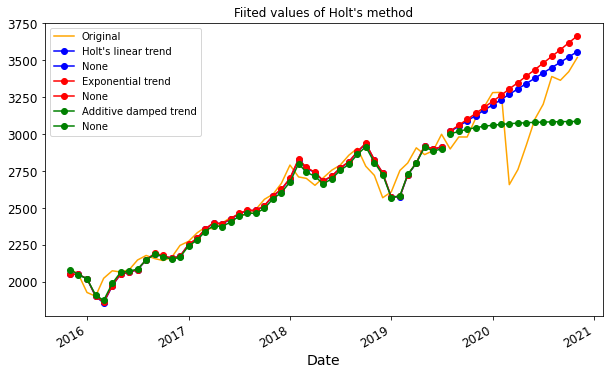

In [48]:
plt.plot(df_close_month,color='orange',label="Original")
# plot 4
fit_4= Holt(train_df_1).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
forecast_4= fit_4.forecast(16).rename("Holt's linear trend")
forecast_4.plot(marker='o', color='blue',legend=True)
fit_4.fittedvalues.plot(marker='o',  color='blue')

# plot 5
fit_5= Holt(train_df_1, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
forecast_5= fit_5.forecast(16).rename("Exponential trend")
forecast_5.plot(marker='o', color='red',legend=True)
fit_5.fittedvalues.plot(marker='o',  color='red')

# plot 6
fit_6= Holt(train_df_1, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
forecast_6= fit_6.forecast(16).rename("Additive damped trend")
forecast_6.plot(marker='o', color='green',legend=True)
fit_6.fittedvalues.plot(marker='o',  color='green')
plt.title("Fiited values of Holt's method")
plt.legend()
plt.show()

### Prediction Using Holt’s model

In [49]:
test_df.head()

Date
2019-08-01   2898.17257592
2019-09-01   2979.19866536
2019-10-01   2978.98676128
2019-11-01   3105.80598958
2019-12-01   3181.54837135
Freq: MS, Name: Close, dtype: float64

In [50]:
print(forecast_4.head(5))


2019-08-01   3016.18850459
2019-09-01   3052.19850828
2019-10-01   3088.20851198
2019-11-01   3124.21851568
2019-12-01   3160.22851938
Freq: MS, Name: Holt's linear trend, dtype: float64


In [51]:
print(forecast_5.head(5))


2019-08-01   3019.28281903
2019-09-01   3058.41457680
2019-10-01   3098.05350615
2019-11-01   3138.20618036
2019-12-01   3178.87925785
Freq: MS, Name: Exponential trend, dtype: float64


In [52]:
print(forecast_6.head(5))


2019-08-01   2999.56480227
2019-09-01   3017.12314450
2019-10-01   3031.16981829
2019-11-01   3042.40715732
2019-12-01   3051.39702854
Freq: MS, Name: Additive damped trend, dtype: float64


In [53]:
print(f"RMSE for Holt's linear trend : {math.sqrt(mean_squared_error(test_df_1, forecast_4))}")
print(f"RMSE for Exponential trend : {math.sqrt(mean_squared_error(test_df_1, forecast_5))}")
print(f"RMSE for Additive damped trend :{math.sqrt(mean_squared_error(test_df_1, forecast_6))}")

RMSE for Holt's linear trend : 254.7468187625225
RMSE for Exponential trend : 288.7017424935487
RMSE for Additive damped trend :238.53592154909217


### The lowest value of RMSE is when the model follows exponential trend with α=0.8 & β* = 0.2 

### TRIPLE EXPONENTIAL SMOOTHING HOLT’S WINTERS TREND AND SEASONALITY METHOD:

    Holt and Winters extended Holt’s method to capture seasonality. The Holt-Winters seasonal method comprises the forecast equation and three smoothing equations. It has three parameters alpha which is the level, Beta* which is the trend, and gamma which is the seasonality. The additive method is preferred when the seasonal variations are roughly constant through the series, while the multiplicative method is preferred when the seasonal variations are changing proportionally to the level of the series.
    
### Holt- Winter’s Trend and Seasonality Method for Multiplicative Model:

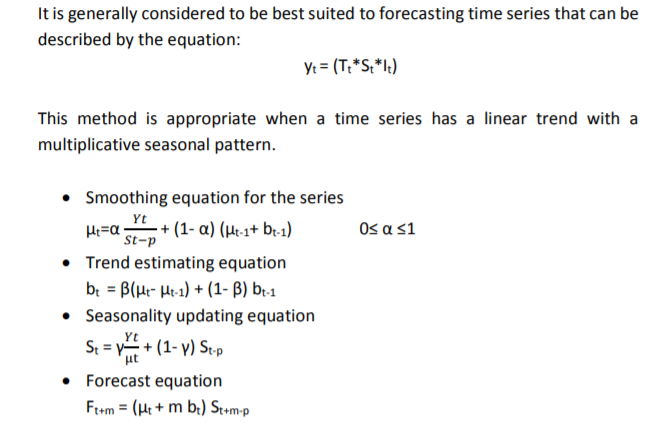

Where,
$µ_{t}$ : Exponentially smoothed value of the series at time t ,

$y_{t}$ : Actual observation of time series at time t ,

$T_{t}$ : Trend Estimate ,

$α$ : Exponential Smoothing Constant for the data ,

$β$ : Smoothing constant for trend ,

$γ$ : Smoothing constant for seasonality ,

$F_{t+m}$ : m period ahead forecasted value ,

$p$ : the period of seasonality ( p=4 for quarterly data & p=12 for monthly data.

### Holt- Winter’s Trend and Seasonality Method for Additive Model:

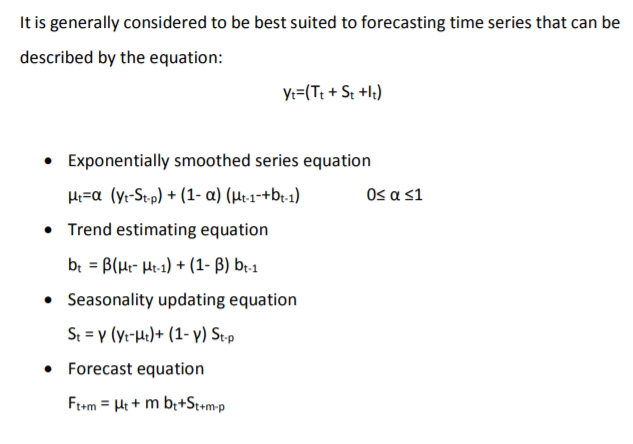

Where,
$µ_{t}$ : Exponentially smoothed value of the series at time t ,

$y_{t}$ : Actual observation of time series at time t ,

$T_{t}$ : Trend Estimate ,

$α$ : Exponential Smoothing Constant for the data ,

$β$ : Smoothing constant for trend ,

$γ$ : Smoothing constant for seasonality ,

$F_{t+m}$ : m period ahead forecasted value ,

$p$ : the period of seasonality ( p=4 for quarterly data & p=12 for monthly data).

### Modeling Using Holt’s Winter Model

    1.In fit 9, we use additive trend, additive seasonal of period season_length=12, and a Box-Cox transformation. 
    2.In fit 10, we use additive trend, multiplicative seasonal of period season_length=12, and a Box-Cox transformation. 
    3.In fit 11, we use additive damped trend, additive seasonal of period season_length=12, and a Box-Cox transformation. 
    4.In fit 12, we use multiplicative damped trend, multiplicative seasonal of period season_length=4, and a Box-Cox transformation.
    
### Box-Cox Transformation

    A Box-Cox transformation is a transformation of a non-normal dependent variable into a normal shape. Normality is an important assumption for many statistical techniques; if your data isn’t normal, applying a Box-Cox means that you are able to run a broader number of tests.

In [54]:
test_df_1=pd.DataFrame(test_df_1)

# Fit 9

            Predicted_values         Close         RMSE
Date                                                   
2019-08-01     3043.28400687 2898.17257592 145.11143095
2019-09-01     3047.37427384 2979.19866536  68.17560848
2019-10-01     3057.35880881 2978.98676128  78.37204754
2019-11-01     3034.37464405 3105.80598958  71.43134553
2019-12-01     3026.64674166 3181.54837135 154.90162968
2020-01-01     2952.73243172 3279.13679751 326.40436579
2020-02-01     2954.87053910 3280.88376381 326.01322471
2020-03-01     3068.04343741 2656.98193359 411.06150382
2020-04-01     3127.82870980 2759.02799479 368.80071501
2020-05-01     3141.96221600 2922.43740549 219.52481051
2020-06-01     3174.35413040 3099.55335286  74.80077754
2020-07-01     3244.79719259 3200.27257907  44.52461352
2020-08-01     3288.47613540 3387.95970105  99.48356565
2020-09-01     3292.36878737 3362.48432617  70.11553880
2020-10-01     3301.87260407 3420.35094821 118.47834414
2020-11-01     3279.99859878 3516.81796875 236.8

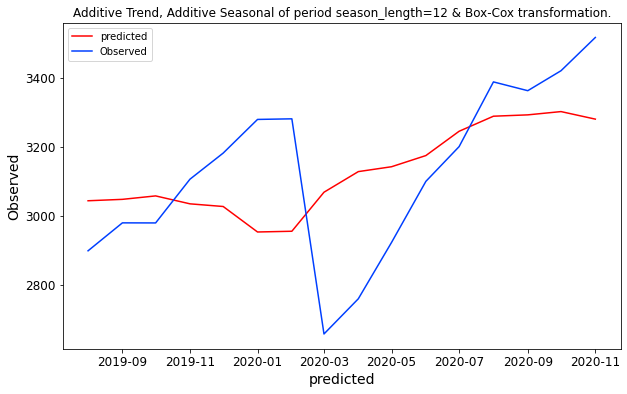

In [56]:
for i in range(1,17):
    fit_9= ExponentialSmoothing(train_df_1, seasonal_periods=12, trend='add', seasonal='add').fit(use_boxcox=True)
    forecast_9= fit_9.forecast(i)
    first_forecast= pd.DataFrame(forecast_9, index= test_df_1.index, columns=['Predicted_values'])
    
    first_forecast = first_forecast.join(test_df_1)
    first_forecast['RMSE']=np.sqrt(((first_forecast.Predicted_values-first_forecast.Close)**2))
    

print(first_forecast)

plt.plot(first_forecast.Predicted_values,color='red',label='predicted')
plt.plot(first_forecast.Close,label='Observed')
plt.xlabel('predicted')
plt.ylabel('Observed')
plt.title("Additive Trend, Additive Seasonal of period season_length=12 & Box-Cox transformation.")
plt.legend()
plt.show()
import warnings
warnings.filterwarnings("ignore")

In [57]:
prediction_first=first_forecast['Predicted_values']
mape_first = np.mean(np.abs(prediction_first - first_forecast['Close'])/np.abs(first_forecast['Close']))
print(f"Mean Absolute Percentage Error for first forecast : {mape_first}")
print(f"Average RMSE value of Fit 9 : {np.mean(first_forecast.RMSE)}")

Mean Absolute Percentage Error for first forecast : 0.057724603677793376
Average RMSE value of Fit 9 : 175.87618072662758


## fit 10

            Predicted_values         Close         RMSE
Date                                                   
2019-08-01     3060.90320313 2898.17257592 162.73062721
2019-09-01     3083.16403940 2979.19866536 103.96537403
2019-10-01     3111.89239572 2978.98676128 132.90563444
2019-11-01     3108.75370653 3105.80598958   2.94771695
2019-12-01     3121.44681343 3181.54837135  60.10155792
2020-01-01     3070.31489201 3279.13679751 208.82190550
2020-02-01     3094.40463960 3280.88376381 186.47912421
2020-03-01     3226.59714566 2656.98193359 569.61521206
2020-04-01     3307.17951477 2759.02799479 548.15151998
2020-05-01     3344.13086659 2922.43740549 421.69346109
2020-06-01     3399.14814743 3099.55335286 299.59479457
2020-07-01     3490.91821908 3200.27257907 290.64564001
2020-08-01     3557.44232471 3387.95970105 169.48262366
2020-09-01     3586.66775523 3362.48432617 224.18342905
2020-10-01     3621.87321214 3420.35094821 201.52226393
2020-11-01     3628.29829523 3516.81796875 111.4

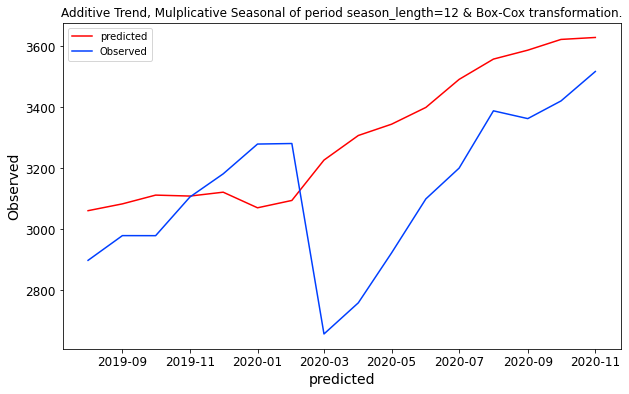

In [58]:
for i in range(1,17):
    fit_10= ExponentialSmoothing(train_df_1, seasonal_periods=12, trend='mul', seasonal='add').fit(use_boxcox=True)
    forecast_10= fit_10.forecast(i)
    second_forecast= pd.DataFrame(forecast_10, index= test_df_1.index, columns=['Predicted_values'])
    
    second_forecast = second_forecast.join(test_df_1)
    second_forecast['RMSE']=np.sqrt(((second_forecast.Predicted_values-second_forecast.Close)**2))
print(second_forecast)

plt.plot(second_forecast.Predicted_values,color='red',label='predicted')
plt.plot(second_forecast.Close,label='Observed')
plt.xlabel('predicted')
plt.ylabel('Observed')
plt.title("Additive Trend, Mulplicative Seasonal of period season_length=12 & Box-Cox transformation.")
plt.legend()
plt.show()

In [59]:
prediction_second=second_forecast['Predicted_values']
mape_second = np.mean(np.abs(prediction_second - second_forecast['Close'])/np.abs(second_forecast['Close']))
print(f"Mean Absolute Percentage Error for second forecast : {mape_second}")
print(f"Average RMSE value of Fit 10 : {np.mean(second_forecast.RMSE)}")

Mean Absolute Percentage Error for second forecast : 0.0767604289262821
Average RMSE value of Fit 10 : 230.89507569369073


## Fit 11

            Predicted_values         Close         RMSE
Date                                                   
2019-08-01     3035.49693612 2898.17257592 137.32436020
2019-09-01     3031.70666542 2979.19866536  52.50800005
2019-10-01     3033.70933303 2978.98676128  54.72257175
2019-11-01     3002.41163301 3105.80598958 103.39435658
2019-12-01     2986.27495970 3181.54837135 195.27341165
2020-01-01     2903.07093405 3279.13679751 376.06586345
2020-02-01     2896.45157474 3280.88376381 384.43218906
2020-03-01     3002.32716438 2656.98193359 345.34523079
2020-04-01     3054.19781575 2759.02799479 295.16982096
2020-05-01     3059.70121112 2922.43740549 137.26380563
2020-06-01     3083.72104750 3099.55335286  15.83230537
2020-07-01     3146.53222568 3200.27257907  53.74035339
2020-08-01     3182.09376943 3387.95970105 205.86593161
2020-09-01     3176.97073808 3362.48432617 185.51358809
2020-10-01     3177.48344035 3420.35094821 242.86750786
2020-11-01     3145.68087118 3516.81796875 371.1

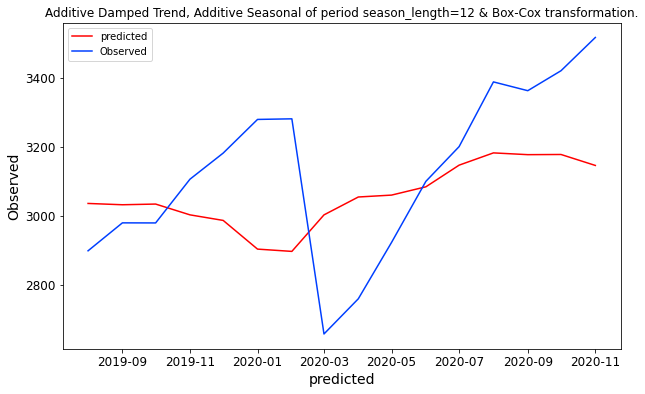

In [60]:
for i in range(1,17):
    fit_11= ExponentialSmoothing(train_df_1, seasonal_periods=12, trend='add', seasonal='add', damped= True).fit(use_boxcox=True)
    forecast_11= fit_11.forecast(i)
    third_forecast= pd.DataFrame(forecast_11, index= test_df_1.index, columns=['Predicted_values'])
    
    third_forecast = third_forecast.join(test_df_1)
    third_forecast['RMSE']=np.sqrt(((third_forecast.Predicted_values-third_forecast.Close)**2))
print(third_forecast)

plt.plot(third_forecast.Predicted_values,color='red',label='predicted')
plt.plot(third_forecast.Close,label='Observed')
plt.xlabel('predicted')
plt.ylabel('Observed')
plt.title("Additive Damped Trend, Additive Seasonal of period season_length=12 & Box-Cox transformation.")
plt.legend()
plt.show()

In [61]:
prediction_third=third_forecast['Predicted_values']
mape_third = np.mean(np.abs(prediction_third - third_forecast['Close'])/np.abs(third_forecast['Close']))
print(f"Mean Absolute Percentage Error for third forecast : {mape_third}")
print(f"Average RMSE value of Fit 11 : {np.mean(third_forecast.RMSE)}")

Mean Absolute Percentage Error for third forecast : 0.0630128813460985
Average RMSE value of Fit 11 : 197.27852462561344


## Fit 12

            Predicted_values         Close         RMSE
Date                                                   
2019-08-01     3078.72318675 2898.17257592 180.55061083
2019-09-01     3089.44353553 2979.19866536 110.24487017
2019-10-01     3097.20377473 2978.98676128 118.21701346
2019-11-01     3057.18273013 3105.80598958  48.62325946
2019-12-01     3033.86333143 3181.54837135 147.68503992
2020-01-01     2905.27977803 3279.13679751 373.85701947
2020-02-01     2878.63546633 3280.88376381 402.24829747
2020-03-01     3063.12135989 2656.98193359 406.13942629
2020-04-01     3181.30694612 2759.02799479 422.27895133
2020-05-01     3211.84464466 2922.43740549 289.40723916
2020-06-01     3268.72350880 3099.55335286 169.17015594
2020-07-01     3398.26824266 3200.27257907 197.99566359
2020-08-01     3485.57005713 3387.95970105  97.61035609
2020-09-01     3493.36853754 3362.48432617 130.88421137
2020-10-01     3497.84274804 3420.35094821  77.49179983
2020-11-01     3448.44728716 3516.81796875  68.3

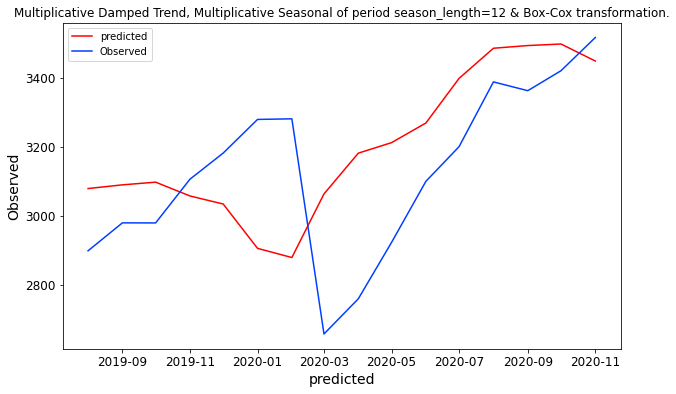

In [62]:
for i in range(1,17):
    fit_12= ExponentialSmoothing(train_df_1, seasonal_periods=12, trend='mul', seasonal='mul', damped=True).fit(use_boxcox=True)
    forecast_12= fit_12.forecast(i)
    fourth_forecast= pd.DataFrame(forecast_12, index= test_df_1.index, columns=['Predicted_values'])
    
    fourth_forecast = fourth_forecast.join(test_df_1)
    fourth_forecast['RMSE']=np.sqrt(((fourth_forecast.Predicted_values-fourth_forecast.Close)**2))
print(fourth_forecast)

plt.plot(fourth_forecast.Predicted_values,color='red',label='predicted')
plt.plot(fourth_forecast.Close,label='Observed')
plt.xlabel('predicted')
plt.ylabel('Observed')
plt.title("Multiplicative Damped Trend, Multiplicative Seasonal of period season_length=12 & Box-Cox transformation.")
plt.legend()
plt.show()

In [63]:
prediction_fourth=fourth_forecast['Predicted_values']
mape = np.mean(np.abs(prediction_fourth - fourth_forecast['Close'])/np.abs(fourth_forecast['Close']))
print(f"Mean Absolute Percentage Error for fourth forecast : {mape}")
print(f"Average RMSE value for Fit 12 : {np.mean(fourth_forecast.RMSE)}")

Mean Absolute Percentage Error for fourth forecast : 0.06680602847237493
Average RMSE value for Fit 12 : 202.54841224794438


#### we can easily see that, the Holt-winter method with Additive trend and seasonality is giving us lowest RMSE(175.23). Therefore, we get the most accurate forecasted values for the testing data of our stock price dataset by using this method
#### MAPE for this method is  around 5.2% implies the model is about 94.8% accurate in predicting the test set observations. 

## The Best Forecasting model is "Fit 9"